In [1]:
# # Mount your Google Drive.
# from google.colab import drive
# drive.mount("/content/drive")

# ! pip install kaggle --quiet

# ! mkdir ~/.kaggle
# kaggle_creds_path = "/content/drive/MyDrive/kaggle.json"
# ! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# competition_name = "predict-energy-behavior-of-prosumers"
# ! kaggle competitions download -c {competition_name}

# ! mkdir kaggle_data
# ! unzip {competition_name + ".zip"} -d kaggle_data

# # Unmount your Google Drive
# drive.flush_and_unmount()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import holidays
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
import plotly.express as px
import datetime
import pickle
import gc
import os
import optuna
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    cross_validate,
    train_test_split,
)
from optuna.integration import LightGBMPruningCallback
from sklearn.metrics import log_loss, mean_squared_error
import holidays

import warnings
warnings.filterwarnings("ignore")

C:\Users\Xiaowei\AppData\Local\Temp\ipykernel_22516\1280145777.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\Xiaowei\miniconda3\envs\kaggle\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# pip install --upgrade scipy

In [4]:
# !pip install pandas numpy matplotlib lightgbm scikit-learn plotly optuna holidays

In [5]:
# pip freeze > requirements.txt

In [6]:
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("display.max_info_columns", 200)

## Load Data

In [7]:
# root = '/kaggle/input/predict-energy-behavior-of-prosumers/'
# root = '/content/kaggle_data/'
root = './'
train_df = pd.read_csv(os.path.join(root, 'train.csv'))

gas_prices_df = pd.read_csv(os.path.join(root, 'gas_prices.csv'))
client_df = pd.read_csv(os.path.join(root, 'client.csv'))

electricity_prices_df = pd.read_csv(
    os.path.join(root, 'electricity_prices.csv'))

forecast_weather_df = pd.read_csv(os.path.join(root, 'forecast_weather.csv'))

historical_weather_df = pd.read_csv(
    os.path.join(root, 'historical_weather.csv'))

# location_df = pd.read_csv('/kaggle/input/locations/county_lon_lats.csv')
location_df = pd.read_csv(os.path.join(root, 'county_lon_lats.csv'))

## Feature Engineering

In [8]:
# import json


# with open(os. path.join(root, f"county_id_to_name_map.json")) as fo:
#     county_id_to_name = json.load(fo)
# print(county_id_to_name)

In [9]:
# counties_locations = {
#     "HARJUMAA": (59.351142, 24.725384),
#     "HIIUMAA": (58.918082, 22.586403),
#     "IDA-VIRUMAA": (59.228971, 27.406654),
#     "JÄRVAMAA": (58.897934, 25.623048),
#     "JÕGEVAMAA": (58.727941, 26.413961),
#     "LÄÄNE-VIRUMAA": (59.267897, 26.363968),
#     "LÄÄNEMAA": (58.975935, 23.772451),
#     "PÄRNUMAA": (58.448793, 24.526469),
#     "PÕLVAMAA": (58.089925, 27.101149),
#     "RAPLAMAA": (58.924451, 24.619842),
#     "SAAREMAA": (58.414075, 22.525137),
#     "TARTUMAA": (58.394168, 26.747568),
#     "VALGAMAA": (57.933466, 26.191360),
#     "VILJANDIMAA": (58.316916, 25.595130),
#     "VÕRUMAA": (57.765485, 27.025669)
# }

In [10]:
# cols_loc = ["latitude", "longitude"]
# weather_locations = historical_weather_df.groupby(
#     cols_loc).size().reset_index()[cols_loc]
# # display(weather_locations)

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   county              int64  
 1   is_business         int64  
 2   product_type        int64  
 3   target              float64
 4   is_consumption      int64  
 5   datetime            object 
 6   data_block_id       int64  
 7   row_id              int64  
 8   prediction_unit_id  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 138.6+ MB


In [12]:
train_df.tail()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60
2018351,15,1,3,196.240,1,2023-05-31 23:00:00,637,2018351,60


In [13]:
train_df.isna().sum()

county                  0
is_business             0
product_type            0
target                528
is_consumption          0
datetime                0
data_block_id           0
row_id                  0
prediction_unit_id      0
dtype: int64

In [14]:
train_df = train_df[train_df['target'].notnull()]

In [15]:
train_df['datetime'] = pd.to_datetime(train_df['datetime'])

In [16]:
train_df.shape

(2017824, 9)

In [17]:
estonian_holidays = holidays.country_holidays('EE', years=range(2021, 2026))
estonian_holidays = list(estonian_holidays.keys())

def add_holidays_features(df):
    df['country_holiday'] = df['datetime'].apply(
        lambda row: (row.date() in estonian_holidays) * 1)
    return df

train_df = add_holidays_features(train_df)

In [18]:
train_df[train_df['datetime'] == '2022-01-01'].head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,country_holiday
366048,0,0,1,0.000,0,2022-01-01,122,366048,0,1
366049,0,0,1,442.226,1,2022-01-01,122,366049,0,1
366050,0,0,2,0.000,0,2022-01-01,122,366050,1,1
366051,0,0,2,44.899,1,2022-01-01,122,366051,1,1
366052,0,0,3,0.015,0,2022-01-01,122,366052,2,1


In [19]:
location_df.head()

,Unnamed: 0,county,longitude,latitude
0,0,0,24.2,59.1
1,1,0,25.2,59.1
2,2,0,23.7,59.4
3,3,0,24.2,59.4
4,4,0,24.7,59.4


In [20]:
location_df = location_df.drop('Unnamed: 0', axis=1)

In [21]:
gas_prices_df.isna().sum()

forecast_date            0
lowest_price_per_mwh     0
highest_price_per_mwh    0
origin_date              0
data_block_id            0
dtype: int64

In [22]:
client_df.isna().sum()

product_type          0
county                0
eic_count             0
installed_capacity    0
is_business           0
date                  0
data_block_id         0
dtype: int64

In [23]:
electricity_prices_df.isna().sum()

forecast_date    0
euros_per_mwh    0
origin_date      0
data_block_id    0
dtype: int64

In [24]:
forecast_weather_df.isna().sum()

latitude                             0
longitude                            0
origin_datetime                      0
hours_ahead                          0
temperature                          0
dewpoint                             0
cloudcover_high                      0
cloudcover_low                       0
cloudcover_mid                       0
cloudcover_total                     0
10_metre_u_wind_component            0
10_metre_v_wind_component            0
data_block_id                        0
forecast_datetime                    0
direct_solar_radiation               0
surface_solar_radiation_downwards    2
snowfall                             0
total_precipitation                  0
dtype: int64

In [25]:
historical_weather_df.isna().sum()

datetime                  0
temperature               0
dewpoint                  0
rain                      0
snowfall                  0
surface_pressure          0
cloudcover_total          0
cloudcover_low            0
cloudcover_mid            0
cloudcover_high           0
windspeed_10m             0
winddirection_10m         0
shortwave_radiation       0
direct_solar_radiation    0
diffuse_radiation         0
latitude                  0
longitude                 0
data_block_id             0
dtype: int64

In [26]:
location_df.isna().sum()

county       0
longitude    0
latitude     0
dtype: int64

In [27]:
location_df.head()

,county,longitude,latitude
0,0,24.2,59.1
1,0,25.2,59.1
2,0,23.7,59.4
3,0,24.2,59.4
4,0,24.7,59.4


In [28]:
forecast_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424512 entries, 0 to 3424511
Data columns (total 18 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   latitude                           float64
 1   longitude                          float64
 2   origin_datetime                    object 
 3   hours_ahead                        int64  
 4   temperature                        float64
 5   dewpoint                           float64
 6   cloudcover_high                    float64
 7   cloudcover_low                     float64
 8   cloudcover_mid                     float64
 9   cloudcover_total                   float64
 10  10_metre_u_wind_component          float64
 11  10_metre_v_wind_component          float64
 12  data_block_id                      int64  
 13  forecast_datetime                  object 
 14  direct_solar_radiation             float64
 15  surface_solar_radiation_downwards  float64
 16  snowfall          

In [29]:
forecast_weather_df[['latitude', 'longitude']] = forecast_weather_df[[
    'latitude', 'longitude']].astype(float).round(1)

print(forecast_weather_df.info())
display(forecast_weather_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424512 entries, 0 to 3424511
Data columns (total 18 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   latitude                           float64
 1   longitude                          float64
 2   origin_datetime                    object 
 3   hours_ahead                        int64  
 4   temperature                        float64
 5   dewpoint                           float64
 6   cloudcover_high                    float64
 7   cloudcover_low                     float64
 8   cloudcover_mid                     float64
 9   cloudcover_total                   float64
 10  10_metre_u_wind_component          float64
 11  10_metre_v_wind_component          float64
 12  data_block_id                      int64  
 13  forecast_datetime                  object 
 14  direct_solar_radiation             float64
 15  surface_solar_radiation_downwards  float64
 16  snowfall          

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 02:00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2021-09-01 02:00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2021-09-01 02:00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2021-09-01 02:00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
4,57.6,23.7,2021-09-01 02:00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0


In [30]:
forecast_weather_df = forecast_weather_df.merge(
    location_df, how='left', on=['longitude', 'latitude'])

In [31]:
forecast_weather_df.head()

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation,county
0,57.6,21.7,2021-09-01 02:00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,NaN
1,57.6,22.2,2021-09-01 02:00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,NaN
2,57.6,22.7,2021-09-01 02:00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,NaN
3,57.6,23.2,2021-09-01 02:00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,10.0
4,57.6,23.7,2021-09-01 02:00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,NaN


In [32]:
forecast_weather_df.shape

(3424512, 19)

In [33]:
forecast_weather_df.dropna(axis=0, inplace=True)

In [34]:
forecast_weather_df.shape

(2293200, 19)

In [35]:
forecast_weather_df.head()

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation,county
3,57.6,23.2,2021-09-01 02:00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,10.0
10,57.6,26.7,2021-09-01 02:00:00,1,9.876489,9.120386,0.000000,0.025940,0.003006,0.026001,1.048755,-2.526303,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,15.0
11,57.6,27.2,2021-09-01 02:00:00,1,10.815576,10.046899,0.747406,0.083191,0.000000,0.761780,1.183276,-3.873715,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,15.0
14,57.9,21.7,2021-09-01 02:00:00,1,16.050439,12.355493,0.886078,0.051636,0.000092,0.889587,0.426929,-10.098569,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,10.0
15,57.9,22.2,2021-09-01 02:00:00,1,14.418481,11.374536,0.855011,0.003052,0.000015,0.855301,0.902514,-6.924008,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,10.0


In [36]:
forecast_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2293200 entries, 3 to 3424508
Data columns (total 19 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   latitude                           float64
 1   longitude                          float64
 2   origin_datetime                    object 
 3   hours_ahead                        int64  
 4   temperature                        float64
 5   dewpoint                           float64
 6   cloudcover_high                    float64
 7   cloudcover_low                     float64
 8   cloudcover_mid                     float64
 9   cloudcover_total                   float64
 10  10_metre_u_wind_component          float64
 11  10_metre_v_wind_component          float64
 12  data_block_id                      int64  
 13  forecast_datetime                  object 
 14  direct_solar_radiation             float64
 15  surface_solar_radiation_downwards  float64
 16  snowfall               

In [37]:
forecast_weather_df['county'] = forecast_weather_df['county'].astype('int64')
forecast_weather_df.drop(['origin_datetime', 'latitude', 'longitude',
                         'hours_ahead', 'data_block_id'], axis=1, inplace=True)

In [38]:
# forecast_weather_df['origin_datetime'] = pd.to_datetime(forecast_weather_df['origin_datetime'])
forecast_weather_df['forecast_datetime'] = pd.to_datetime(
    forecast_weather_df['forecast_datetime'])
# forecast_weather_df.rename(
#     columns={'forecast_datetime': 'datetime'}, inplace=True)

In [39]:
forecast_weather_datetime = forecast_weather_df.groupby(
    [forecast_weather_df['forecast_datetime'].dt.to_period('h')])[
        list(forecast_weather_df.drop(['county', 'forecast_datetime'], axis=1)
             .columns)].mean().reset_index()

In [40]:
forecast_weather_datetime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15310 entries, 0 to 15309
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype    
---  ------                             --------------  -----    
 0   forecast_datetime                  15310 non-null  period[h]
 1   temperature                        15310 non-null  float64  
 2   dewpoint                           15310 non-null  float64  
 3   cloudcover_high                    15310 non-null  float64  
 4   cloudcover_low                     15310 non-null  float64  
 5   cloudcover_mid                     15310 non-null  float64  
 6   cloudcover_total                   15310 non-null  float64  
 7   10_metre_u_wind_component          15310 non-null  float64  
 8   10_metre_v_wind_component          15310 non-null  float64  
 9   direct_solar_radiation             15310 non-null  float64  
 10  surface_solar_radiation_downwards  15310 non-null  float64  
 11  snowfall                    

In [41]:
forecast_weather_df.head()

,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation,county
3,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,10
10,9.876489,9.120386,0.000000,0.025940,0.003006,0.026001,1.048755,-2.526303,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,15
11,10.815576,10.046899,0.747406,0.083191,0.000000,0.761780,1.183276,-3.873715,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,15
14,16.050439,12.355493,0.886078,0.051636,0.000092,0.889587,0.426929,-10.098569,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,10
15,14.418481,11.374536,0.855011,0.003052,0.000015,0.855301,0.902514,-6.924008,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,10


In [42]:
forecast_weather_datetime['forecast_datetime'] = pd.to_datetime(
    forecast_weather_datetime['forecast_datetime'].dt.to_timestamp())
forecast_weather_datetime.rename(
    columns={'forecast_datetime': 'datetime'}, inplace=True)

In [43]:
forecast_weather_datetime.head()

,datetime,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,2021-09-01 03:00:00,13.014066,10.531545,0.256954,0.213331,0.069662,0.438023,1.970332,-5.205125,0.000000,0.000000,0.0,0.000000e+00
1,2021-09-01 04:00:00,12.891813,10.474813,0.278619,0.178085,0.079571,0.427232,2.092311,-5.197120,0.000000,0.000000,0.0,1.151164e-06
2,2021-09-01 05:00:00,12.693667,10.327287,0.244363,0.120304,0.068174,0.368063,2.319048,-5.227491,0.000000,0.000000,0.0,8.145968e-07
3,2021-09-01 06:00:00,12.666698,10.257059,0.244026,0.108244,0.088197,0.380928,2.460921,-5.257574,57.310637,9.754364,0.0,7.553895e-07
4,2021-09-01 07:00:00,13.212046,10.436997,0.216526,0.117397,0.073299,0.344576,2.581852,-5.341152,257.277830,82.380557,0.0,1.347065e-06


In [44]:
forecast_weather_datetime_county = forecast_weather_df.groupby(['county', forecast_weather_df['forecast_datetime'].dt.to_period('h')])[
    list(forecast_weather_df.drop(['county', 'forecast_datetime'], axis=1).columns)].mean().reset_index()

In [45]:
forecast_weather_datetime_county.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229650 entries, 0 to 229649
Data columns (total 14 columns):
 #   Column                             Non-Null Count   Dtype    
---  ------                             --------------   -----    
 0   county                             229650 non-null  int64    
 1   forecast_datetime                  229650 non-null  period[h]
 2   temperature                        229650 non-null  float64  
 3   dewpoint                           229650 non-null  float64  
 4   cloudcover_high                    229650 non-null  float64  
 5   cloudcover_low                     229650 non-null  float64  
 6   cloudcover_mid                     229650 non-null  float64  
 7   cloudcover_total                   229650 non-null  float64  
 8   10_metre_u_wind_component          229650 non-null  float64  
 9   10_metre_v_wind_component          229650 non-null  float64  
 10  direct_solar_radiation             229650 non-null  float64  
 11  surface_solar

In [46]:
forecast_weather_datetime_county['forecast_datetime'] = pd.to_datetime(
    forecast_weather_datetime_county['forecast_datetime'].dt.to_timestamp())
forecast_weather_datetime_county.rename(
    columns={'forecast_datetime': 'datetime'}, inplace=True)

In [47]:
historical_weather_df[['latitude', 'longitude']] = historical_weather_df[[
    'latitude', 'longitude']].astype(float).round(1)
historical_weather_df = historical_weather_df.merge(
    location_df, how='left', on=['longitude', 'latitude'])
historical_weather_df.dropna(axis=0, inplace=True)
historical_weather_df.head()

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id,county
3,2021-09-01 00:00:00,14.6,11.5,0.0,0.0,1017.3,0,0,0,0,8.083333,297,358.0,277.0,81.0,57.6,23.2,1.0,10.0
10,2021-09-01 00:00:00,13.0,11.5,0.0,0.0,998.5,100,85,17,98,4.027778,354,0.0,0.0,0.0,57.6,26.7,1.0,15.0
11,2021-09-01 00:00:00,13.0,12.1,0.1,0.0,988.9,100,100,39,99,3.805556,360,0.0,0.0,0.0,57.6,27.2,1.0,15.0
14,2021-09-01 00:00:00,13.3,10.7,0.0,0.0,1016.2,51,35,0,64,7.611111,5,0.0,0.0,0.0,57.9,21.7,1.0,10.0
15,2021-09-01 00:00:00,14.4,11.3,0.0,0.0,1016.2,51,35,0,64,7.611111,5,0.0,0.0,0.0,57.9,22.2,1.0,10.0


In [48]:
historical_weather_df.drop(['latitude', 'longitude'], axis=1, inplace=True)
historical_weather_df.head()

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,data_block_id,county
3,2021-09-01 00:00:00,14.6,11.5,0.0,0.0,1017.3,0,0,0,0,8.083333,297,358.0,277.0,81.0,1.0,10.0
10,2021-09-01 00:00:00,13.0,11.5,0.0,0.0,998.5,100,85,17,98,4.027778,354,0.0,0.0,0.0,1.0,15.0
11,2021-09-01 00:00:00,13.0,12.1,0.1,0.0,988.9,100,100,39,99,3.805556,360,0.0,0.0,0.0,1.0,15.0
14,2021-09-01 00:00:00,13.3,10.7,0.0,0.0,1016.2,51,35,0,64,7.611111,5,0.0,0.0,0.0,1.0,10.0
15,2021-09-01 00:00:00,14.4,11.3,0.0,0.0,1016.2,51,35,0,64,7.611111,5,0.0,0.0,0.0,1.0,10.0


In [49]:
historical_weather_df['county'] = historical_weather_df['county'].astype(
    'int64')
historical_weather_df['datetime'] = pd.to_datetime(
    historical_weather_df['datetime'])

In [50]:
historical_weather_datetime = historical_weather_df.groupby(
    [historical_weather_df['datetime'].dt.to_period('h')])[
        list(historical_weather_df.drop(['county', 'datetime', 'data_block_id'], axis=1).columns)].mean().reset_index()
historical_weather_datetime['datetime'] = pd.to_datetime(
    historical_weather_datetime['datetime'].dt.to_timestamp())
historical_weather_datetime = historical_weather_datetime.merge(
    historical_weather_df[['datetime', 'data_block_id']], how='left', on='datetime')

In [51]:
historical_weather_datetime.head()

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,data_block_id
0,2021-09-01,13.109333,10.790667,0.001333,0.0,1009.298667,50.986667,47.68,3.813333,23.026667,4.978148,321.333333,4.773333,3.693333,1.08,1.0
1,2021-09-01,13.109333,10.790667,0.001333,0.0,1009.298667,50.986667,47.68,3.813333,23.026667,4.978148,321.333333,4.773333,3.693333,1.08,1.0
2,2021-09-01,13.109333,10.790667,0.001333,0.0,1009.298667,50.986667,47.68,3.813333,23.026667,4.978148,321.333333,4.773333,3.693333,1.08,1.0
3,2021-09-01,13.109333,10.790667,0.001333,0.0,1009.298667,50.986667,47.68,3.813333,23.026667,4.978148,321.333333,4.773333,3.693333,1.08,1.0
4,2021-09-01,13.109333,10.790667,0.001333,0.0,1009.298667,50.986667,47.68,3.813333,23.026667,4.978148,321.333333,4.773333,3.693333,1.08,1.0


In [52]:
historical_weather_datetime_county = historical_weather_df.groupby(['county', historical_weather_df['datetime'].dt.to_period(
    'h')])[list(historical_weather_df.drop(['county', 'datetime', 'data_block_id'], axis=1).columns)].mean().reset_index()
historical_weather_datetime_county['datetime'] = pd.to_datetime(
    historical_weather_datetime_county['datetime'].dt.to_timestamp())
historical_weather_datetime_county = historical_weather_datetime_county.merge(
    historical_weather_df[['datetime', 'data_block_id']], how='left', on='datetime')

In [53]:
display(electricity_prices_df.head())
electricity_prices_df.info()

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15286 entries, 0 to 15285
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   forecast_date  15286 non-null  object 
 1   euros_per_mwh  15286 non-null  float64
 2   origin_date    15286 non-null  object 
 3   data_block_id  15286 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 477.8+ KB


In [54]:
electricity_prices_df['forecast_date'] = pd.to_datetime(
    electricity_prices_df['forecast_date'])
electricity_prices_df['origin_date'] = pd.to_datetime(
    electricity_prices_df['origin_date'])
electricity_prices_df['hour'] = electricity_prices_df['forecast_date'].dt.hour
electricity_prices_df = electricity_prices_df.rename(
    columns={'forecast_date': 'datetime'})

In [55]:
client_df['data_block_id'] -= 2

In [56]:
train_df['year'] = train_df['datetime'].dt.year
train_df['month'] = train_df['datetime'].dt.month
train_df['day'] = train_df['datetime'].dt.day
train_df['hour'] = train_df['datetime'].dt.hour
train_df['dayofweek'] = train_df['datetime'].dt.dayofweek
train_df['dayofyear'] = train_df['datetime'].dt.dayofyear

In [57]:
train_df['season'] = pd.cut(train_df['datetime'].dt.month, [
                            0, 3, 6, 9, 12], labels=['1', '2', '3', '4'])

In [58]:
train_df['season'] = train_df['season'].astype('int32')

In [59]:
# train_df[(train_df['is_consumption'] == 0) & (train_df['prediction_unit_id'] == 0)].sort_values('datetime').head(50)

* LightGBM, the gradient boosting framework, is capable of handling categorical features directly, without the need for one-hot encoding. In fact, using one-hot encoding may not be the most efficient approach for tree-based models like LightGBM.

### Dummy variables
Here we have some categorical variables like year, season, month. To include these in our model, we'll need to make binary dummy variables.

In [60]:
# dummy_fields = ['county', 'product_type', 'year', 'month', 'day', 'hour', 'dayofweek', 'dayofyear', 'season']
# for each in dummy_fields:
#     dummies = pd.get_dummies(train_df[each], prefix=each, drop_first=False)
#     train_df = pd.concat([train_df, dummies], axis=1)
# fields_to_drop = ['county', 'product_type', 'year', 'month', 'day', 'hour', 'dayofweek', 'dayofyear', 'season']
# train_df = train_df.drop(fields_to_drop, axis=1)
# train_df.head()

In [61]:
train_df = train_df.merge(client_df.drop(columns=['date']), how='left', on=[
                          'data_block_id', 'county', 'is_business', 'product_type'])
train_df = train_df.merge(gas_prices_df[[
                          'data_block_id', 'lowest_price_per_mwh', 'highest_price_per_mwh']], how='left', on='data_block_id')
train_df = train_df.merge(electricity_prices_df[[
                          'euros_per_mwh', 'hour', 'data_block_id']], how='left', on=['hour', 'data_block_id'])

In [62]:
# train_df[(train_df['is_consumption'] == 0) & (train_df['prediction_unit_id'] == 0)].sort_values('datetime').head(50)

In [63]:
train_df = train_df.merge(forecast_weather_datetime,
                          how='left', on=['datetime'])
train_df = train_df.merge(forecast_weather_datetime_county, how='left', on=[
                          'datetime', 'county'], suffixes=('_fcast_mean', '_fcast_mean_by_county'))

In [64]:
# train_df[(train_df['is_consumption'] == 0) & (train_df['prediction_unit_id'] == 0)].sort_values('datetime').head(50)

In [65]:
historical_weather_datetime['hour'] = historical_weather_datetime['datetime'].dt.hour
historical_weather_datetime_county['hour'] = historical_weather_datetime_county['datetime'].dt.hour

historical_weather_datetime.drop_duplicates(inplace=True)
historical_weather_datetime_county.drop_duplicates(inplace=True)

historical_weather_datetime.drop('datetime', axis=1, inplace=True)
historical_weather_datetime_county.drop('datetime', axis=1, inplace=True)

In [66]:
train_df = train_df.merge(historical_weather_datetime,
                          how='left', on=['data_block_id', 'hour'])
train_df = train_df.merge(historical_weather_datetime_county, how='left', on=[
                          'data_block_id', 'county', 'hour'], suffixes=('_hist_mean', '_hist_mean_by_county'))

In [67]:
train_df[(train_df['is_consumption'] == 0) & (
    train_df['prediction_unit_id'] == 0)].sort_values('datetime').head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,country_holiday,year,month,day,hour,dayofweek,dayofyear,season,eic_count,installed_capacity,lowest_price_per_mwh,highest_price_per_mwh,euros_per_mwh,temperature_fcast_mean,dewpoint_fcast_mean,cloudcover_high_fcast_mean,cloudcover_low_fcast_mean,cloudcover_mid_fcast_mean,cloudcover_total_fcast_mean,10_metre_u_wind_component_fcast_mean,10_metre_v_wind_component_fcast_mean,direct_solar_radiation_fcast_mean,surface_solar_radiation_downwards_fcast_mean,snowfall_fcast_mean,total_precipitation_fcast_mean,temperature_fcast_mean_by_county,dewpoint_fcast_mean_by_county,cloudcover_high_fcast_mean_by_county,cloudcover_low_fcast_mean_by_county,cloudcover_mid_fcast_mean_by_county,cloudcover_total_fcast_mean_by_county,10_metre_u_wind_component_fcast_mean_by_county,10_metre_v_wind_component_fcast_mean_by_county,direct_solar_radiation_fcast_mean_by_county,surface_solar_radiation_downwards_fcast_mean_by_county,snowfall_fcast_mean_by_county,total_precipitation_fcast_mean_by_county,temperature_hist_mean,dewpoint_hist_mean,rain_hist_mean,snowfall_hist_mean,surface_pressure_hist_mean,cloudcover_total_hist_mean,cloudcover_low_hist_mean,cloudcover_mid_hist_mean,cloudcover_high_hist_mean,windspeed_10m_hist_mean,winddirection_10m_hist_mean,shortwave_radiation_hist_mean,direct_solar_radiation_hist_mean,diffuse_radiation_hist_mean,temperature_hist_mean_by_county,dewpoint_hist_mean_by_county,rain_hist_mean_by_county,snowfall_hist_mean_by_county,surface_pressure_hist_mean_by_county,cloudcover_total_hist_mean_by_county,cloudcover_low_hist_mean_by_county,cloudcover_mid_hist_mean_by_county,cloudcover_high_hist_mean_by_county,windspeed_10m_hist_mean_by_county,winddirection_10m_hist_mean_by_county,shortwave_radiation_hist_mean_by_county,direct_solar_radiation_hist_mean_by_county,diffuse_radiation_hist_mean_by_county
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,0,2021,9,1,0,2,244,3,108.0,952.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122,0,0,1,1.132,0,2021-09-01 01:00:00,0,122,0,0,2021,9,1,1,2,244,3,108.0,952.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
244,0,0,1,0.490,0,2021-09-01 02:00:00,0,244,0,0,2021,9,1,2,2,244,3,108.0,952.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
366,0,0,1,0.496,0,2021-09-01 03:00:00,0,366,0,0,2021,9,1,3,2,244,3,108.0,952.89,NaN,NaN,NaN,13.014066,10.531545,0.256954,0.213331,0.069662,0.438023,1.970332,-5.205125,0.0,0.0,0.0,0.000000,13.279187,10.265674,0.192630,0.036087,0.005286,0.215636,2.511035,-5.096591,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
488,0,0,1,0.149,0,2021-09-01 04:00:00,0,488,0,0,2021,9,1,4,2,244,3,108.0,952.89,NaN,NaN,NaN,12.891813,10.474813,0.278619,0.178085,0.079571,0.427232,2.092311,-5.197120,0.0,0.0,0.0,0.000001,12.532385,10.350195,0.060413,0.017731,0.034734,0.098526,2.716622,-4.575157,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
train_df = train_df.groupby(['year', 'day', 'hour'], as_index=False).apply(
    lambda x: x.ffill().bfill()).reset_index()

In [69]:
train_df[(train_df['is_consumption'] == 0) & (
    train_df['prediction_unit_id'] == 0)].sort_values('datetime').head()

,level_0,level_1,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,country_holiday,year,month,day,hour,dayofweek,dayofyear,season,eic_count,installed_capacity,lowest_price_per_mwh,highest_price_per_mwh,euros_per_mwh,temperature_fcast_mean,dewpoint_fcast_mean,cloudcover_high_fcast_mean,cloudcover_low_fcast_mean,cloudcover_mid_fcast_mean,cloudcover_total_fcast_mean,10_metre_u_wind_component_fcast_mean,10_metre_v_wind_component_fcast_mean,direct_solar_radiation_fcast_mean,surface_solar_radiation_downwards_fcast_mean,snowfall_fcast_mean,total_precipitation_fcast_mean,temperature_fcast_mean_by_county,dewpoint_fcast_mean_by_county,cloudcover_high_fcast_mean_by_county,cloudcover_low_fcast_mean_by_county,cloudcover_mid_fcast_mean_by_county,cloudcover_total_fcast_mean_by_county,10_metre_u_wind_component_fcast_mean_by_county,10_metre_v_wind_component_fcast_mean_by_county,direct_solar_radiation_fcast_mean_by_county,surface_solar_radiation_downwards_fcast_mean_by_county,snowfall_fcast_mean_by_county,total_precipitation_fcast_mean_by_county,temperature_hist_mean,dewpoint_hist_mean,rain_hist_mean,snowfall_hist_mean,surface_pressure_hist_mean,cloudcover_total_hist_mean,cloudcover_low_hist_mean,cloudcover_mid_hist_mean,cloudcover_high_hist_mean,windspeed_10m_hist_mean,winddirection_10m_hist_mean,shortwave_radiation_hist_mean,direct_solar_radiation_hist_mean,diffuse_radiation_hist_mean,temperature_hist_mean_by_county,dewpoint_hist_mean_by_county,rain_hist_mean_by_county,snowfall_hist_mean_by_county,surface_pressure_hist_mean_by_county,cloudcover_total_hist_mean_by_county,cloudcover_low_hist_mean_by_county,cloudcover_mid_hist_mean_by_county,cloudcover_high_hist_mean_by_county,windspeed_10m_hist_mean_by_county,winddirection_10m_hist_mean_by_county,shortwave_radiation_hist_mean_by_county,direct_solar_radiation_hist_mean_by_county,diffuse_radiation_hist_mean_by_county
0,0,0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,0,2021,9,1,0,2,244,3,108.0,952.89,50.15,69.99,71.36,9.322674,5.718511,0.205072,0.601042,0.811219,0.906914,-2.055299,4.877141,0.0,0.0,0.0,0.000069,9.205896,4.282617,0.132951,0.503769,0.874930,0.965574,-3.168878,4.505805,0.0,0.0,0.0,0.000004,8.982667,6.233333,0.0,0.0,1026.648000,85.293333,82.560000,20.013333,1.413333,4.854074,145.973333,3.786667,1.186667,2.600000,8.84,6.71,0.0,0.0,1028.51,93.3,87.6,24.2,0.0,4.169444,143.0,0.0,0.0,0.0
500,1,122,0,0,1,1.132,0,2021-09-01 01:00:00,0,122,0,0,2021,9,1,1,2,244,3,108.0,952.89,50.15,69.99,68.29,9.284634,5.943040,0.241231,0.593761,0.839222,0.922324,-1.779998,4.798000,0.0,0.0,0.0,0.000074,9.160803,4.547412,0.212045,0.607268,0.904364,0.982888,-2.958008,4.631417,0.0,0.0,0.0,0.000033,8.786667,6.000000,0.0,0.0,1026.582667,75.506667,75.066667,13.186667,1.360000,4.886667,144.640000,2.213333,0.360000,1.853333,8.81,6.63,0.0,0.0,1028.45,88.0,87.8,14.9,0.0,4.291667,141.6,0.0,0.0,0.0
1000,2,244,0,0,1,0.490,0,2021-09-01 02:00:00,0,244,0,0,2021,9,1,2,2,244,3,108.0,952.89,50.15,69.99,61.08,9.247521,6.160270,0.299667,0.600129,0.861108,0.932456,-1.540336,4.725409,0.0,0.0,0.0,0.000076,9.103003,4.873560,0.312955,0.706304,0.958383,0.998552,-2.731902,4.771845,0.0,0.0,0.0,0.000061,8.548000,5.752000,0.0,0.0,1026.252000,75.680000,73.986667,15.840000,1.333333,4.958148,143.333333,1.333333,0.213333,1.120000,8.61,6.39,0.0,0.0,1028.09,91.0,86.2,22.6,0.0,4.327778,141.5,0.0,0.0,0.0
1500,3,366,0,0,1,0.496,0,2021-09-01 03:00:00,0,366,0,0,2021,9,1,3,2,244,3,108.0,952.89,50.15,69.99,59.09,13.014066,10.531545,0.256954,0.213331,0.069662,0.438023,1.970332,-5.205125,0.0,0.0,0.0,0.000000,13.279187,10.265674,0.192630,0.036087,0.005286,0.215636,2.511035,-5.096591,0.0,0.0,0.0,0.000000,8.352000,5.490667,0.0,0.0,1026.032000,70.173333,68.800000,14.066667,1.333333,5.021852,141.893333,0.533333,0.080000,0.453333,8.35,5.95,0.0,0.0,1027.91,82.2,79.7,17.2,0.0,4.338889,140.1,0.0,0.0,0.0
2000,4,488,0,0,1,0.149,0,2021-09-01 04:00:00,0,488,0,0,2021,9,1,4,2,244,3,108.0,952.89,50.15,69.99,62.13,12.891813,

In [70]:
train_df.drop(['level_0', 'level_1', 'row_id',
              'data_block_id'], axis=1, inplace=True)

In [71]:
# train_df.isna().sum()

In [72]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017824 entries, 0 to 2017823
Data columns (total 72 columns):
 #   Column                                                  Dtype         
---  ------                                                  -----         
 0   county                                                  int64         
 1   is_business                                             int64         
 2   product_type                                            int64         
 3   target                                                  float64       
 4   is_consumption                                          int64         
 5   datetime                                                datetime64[ns]
 6   prediction_unit_id                                      int64         
 7   country_holiday                                         int64         
 8   year                                                    int32         
 9   month                                         

In [73]:
# location_df.nunique()

# location_df.latitude.unique()

# location_df[['latitude', 'longitude']].value_counts()

In [74]:
train_df['sin_dayofyear'] = (np.pi * np.sin(train_df['dayofyear']) / 178)
train_df['cos_dayofyear'] = (np.pi * np.cos(train_df['dayofyear']) / 178)

In [75]:
from copy import deepcopy as dc


def shift_dataframe(df, n_steps):
    df_deepcopy = dc(
        df[['datetime', 'prediction_unit_id', 'is_consumption', 'target']])
    for i in range(2, n_steps+1):
        col_name = f'_{i}_days_ago'
        df_deepcopy['datetime'] = df['datetime'] + pd.DateOffset(days=i)
        df = df.merge(df_deepcopy,
                      how='left',
                      on=['datetime', 'prediction_unit_id', 'is_consumption'],
                      suffixes=('', col_name)
                      )
    return df

lookback = 7
train_df = shift_dataframe(train_df, lookback)
# shifted_df.head()

In [76]:
train_df[(train_df['is_consumption'] == 0) & (
    train_df['prediction_unit_id'] == 0)].sort_values('datetime').head(50)

,county,is_business,product_type,target,is_consumption,datetime,prediction_unit_id,country_holiday,year,month,day,hour,dayofweek,dayofyear,season,eic_count,installed_capacity,lowest_price_per_mwh,highest_price_per_mwh,euros_per_mwh,temperature_fcast_mean,dewpoint_fcast_mean,cloudcover_high_fcast_mean,cloudcover_low_fcast_mean,cloudcover_mid_fcast_mean,cloudcover_total_fcast_mean,10_metre_u_wind_component_fcast_mean,10_metre_v_wind_component_fcast_mean,direct_solar_radiation_fcast_mean,surface_solar_radiation_downwards_fcast_mean,snowfall_fcast_mean,total_precipitation_fcast_mean,temperature_fcast_mean_by_county,dewpoint_fcast_mean_by_county,cloudcover_high_fcast_mean_by_county,cloudcover_low_fcast_mean_by_county,cloudcover_mid_fcast_mean_by_county,cloudcover_total_fcast_mean_by_county,10_metre_u_wind_component_fcast_mean_by_county,10_metre_v_wind_component_fcast_mean_by_county,direct_solar_radiation_fcast_mean_by_county,surface_solar_radiation_downwards_fcast_mean_by_county,snowfall_fcast_mean_by_county,total_precipitation_fcast_mean_by_county,temperature_hist_mean,dewpoint_hist_mean,rain_hist_mean,snowfall_hist_mean,surface_pressure_hist_mean,cloudcover_total_hist_mean,cloudcover_low_hist_mean,cloudcover_mid_hist_mean,cloudcover_high_hist_mean,windspeed_10m_hist_mean,winddirection_10m_hist_mean,shortwave_radiation_hist_mean,direct_solar_radiation_hist_mean,diffuse_radiation_hist_mean,temperature_hist_mean_by_county,dewpoint_hist_mean_by_county,rain_hist_mean_by_county,snowfall_hist_mean_by_county,surface_pressure_hist_mean_by_county,cloudcover_total_hist_mean_by_county,cloudcover_low_hist_mean_by_county,cloudcover_mid_hist_mean_by_county,cloudcover_high_hist_mean_by_county,windspeed_10m_hist_mean_by_county,winddirection_10m_hist_mean_by_county,shortwave_radiation_hist_mean_by_county,direct_solar_radiation_hist_mean_by_county,diffuse_radiation_hist_mean_by_county,sin_dayofyear,cos_dayofyear,target_2_days_ago,target_3_days_ago,target_4_days_ago,target_5_days_ago,target_6_days_ago,target_7_days_ago
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,2021,9,1,0,2,244,3,108.0,952.89,50.15,69.99,71.36,9.322674,5.718511,0.205072,0.601042,0.811219,0.906914,-2.055299,4.877141,0.000000,0.000000,0.0,6.877303e-05,9.205896,4.282617,0.132951,0.503769,0.874930,0.965574,-3.168878,4.505805,0.000000,0.000000,0.0,4.100800e-06,8.982667,6.233333,0.000000,0.0,1026.648000,85.293333,82.560000,20.013333,1.413333,4.854074,145.973333,3.786667,1.186667,2.600000,8.84,6.71,0.00,0.0,1028.51,93.3,87.6,24.2,0.0,4.169444,143.0,0.0,0.0,0.0,-0.015259,0.008870,NaN,NaN,NaN,NaN,NaN,NaN
500,0,0,1,1.132,0,2021-09-01 01:00:00,0,0,2021,9,1,1,2,244,3,108.0,952.89,50.15,69.99,68.29,9.284634,5.943040,0.241231,0.593761,0.839222,0.922324,-1.779998,4.798000,0.000000,0.000000,0.0,7.384857e-05,9.160803,4.547412,0.212045,0.607268,0.904364,0.982888,-2.958008,4.631417,0.000000,0.000000,0.0,3.331900e-05,8.786667,6.000000,0.000000,0.0,1026.582667,75.506667,75.066667,13.186667,1.360000,4.886667,144.640000,2.213333,0.360000,1.853333,8.81,6.63,0.00,0.0,1028.45,88.0,87.8,14.9,0.0,4.291667,141.6,0.0,0.0,0.0,-0.015259,0.008870,NaN,NaN,NaN,NaN,NaN,NaN
1000,0,0,1,0.490,0,2021-09-01 02:00:00,0,0,2021,9,1,2,2,244,3,108.0,952.89,50.15,69.99,61.08,9.247521,6.160270,0.299667,0.600129,0.861108,0.932456,-1.540336,4.725409,0.000000,0.000000,0.0,7.581711e-05,9.103003,4.873560,0.312955,0.706304,0.958383,0.998552,-2.731902,4.771845,0.000000,0.000000,0.0,6.129444e-05,8.548000,5.752000,0.000000,0.0,1026.252000,75.680000,73.986667,15.840000,1.333333,4.958148,143.333333,1.333333,0.213333,1.120000,8.61,6.39,0.00,0.0,1028.09,91.0,86.2,22.6,0.0,4.327778,141.5,0.0,0.0,0.0,-0.015259,0.008870,NaN,NaN,NaN,NaN,NaN,NaN
1500,0,0,1,0.496,0,2021-09-01 03:00:00,0,0,2021,9,1,3,2,244,3,108.0,952.89,50.15,69.99,59.09,13.014066,10.531545,0.256954,0.213331,0.069662,0.438023,1.970332,-5.205125,0.000000,0.000000,0.0,0.000000e+00,13.279187,10.265674,0.192630,0.036087,0.005286,0.215636,2.511035,-5.096591,0.000000,0.000000,0.0,0.000000e+

In [77]:
train_df['datetime'] = train_df['datetime'].astype('int64')

In [78]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017824 entries, 0 to 2017823
Data columns (total 80 columns):
 #   Column                                                  Dtype  
---  ------                                                  -----  
 0   county                                                  int64  
 1   is_business                                             int64  
 2   product_type                                            int64  
 3   target                                                  float64
 4   is_consumption                                          int64  
 5   datetime                                                int64  
 6   prediction_unit_id                                      int64  
 7   country_holiday                                         int64  
 8   year                                                    int32  
 9   month                                                   int32  
 10  day                                                   

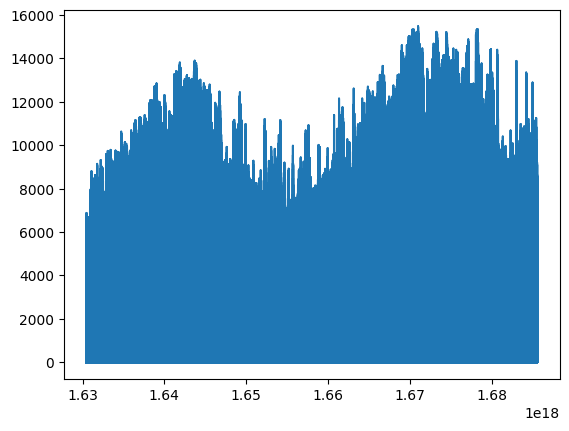

In [79]:
x_df = train_df['datetime']
y_df = train_df['target']
plt.plot(x_df, y_df)
plt.show()

## Data Splitting

In [80]:
from sklearn.model_selection import train_test_split
cat_features = ['county', 'is_business', 'product_type', 'is_consumption', 'prediction_unit_id',
                'country_holiday', 'year', 'month', 'day', 'hour', 'dayofweek', 'season']
# X = train_df.drop('target', axis=1)
# y = train_df['target']
X = train_df[train_df['is_consumption'] != 0].drop('target', axis=1)
y = train_df[train_df['is_consumption'] != 0]['target']
# Assuming X and y are your features and target variable
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42)

In [81]:
X2 = train_df[train_df['is_consumption'] == 0].drop('target', axis=1)
y2 = train_df[train_df['is_consumption'] == 0]['target']
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(
    X2, y2, test_size=0.2, shuffle=True, random_state=42)

In [82]:
# y = np.asarray(train_df['target'], dtype="str")

## Model Architecture

``` python
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'mse',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    model = lgb.LGBMRegressor(**params, random_state=42)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
    predictions = model.predict(X_valid)
    mse = mean_squared_error(y_valid, predictions)
    return mse
```

``` python
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=600)  # You can adjust the number of trials and timeout
```

``` python
print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('Value: ', trial.value)
print('Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')
```

```
Number of finished trials:  50

Best trial:

Value:  4741.834690071413

Params: 

    num_leaves: 921

    learning_rate: 0.08395818510131589

    feature_fraction: 0.8685805945606881

    bagging_fraction: 0.9435585437902303

    bagging_freq: 4

    min_child_samples: 5
```

In [83]:
# # Create LightGBM datasets
# train_dataset = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
# test_dataset = lgb.Dataset(X_test, label=y_test, reference=train_dataset)

# # Set hyperparameters
# params = {
#     'objective': 'regression',  # for regression tasks
#     'metric': 'mse',  # mean squared error
#     'boosting_type': 'gbdt',  # traditional gradient boosting decision tree
#     'num_leaves': 71,  # maximum number of leaves in one tree
#     'learning_rate': 0.05,
#     'feature_fraction': 0.9,  # randomly select a fraction of features on each iteration
#     'bagging_fraction': 0.8,  # randomly select a fraction of data on each iteration
#     'bagging_freq': 5,  # perform bagging every 5 iterations
#     'verbose': 0  # no printed output during training
# }

In [84]:
# !mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd

In [85]:
# !sudo apt install nvidia-driver-460 nvidia-cuda-toolkit clinfo
# !apt-get update --fix-missing

In [86]:
# params = {
#         'objective': 'regression',
#         'metric': 'mse',
#         'boosting_type': 'gbdt',
#         'num_leaves': 921,
#         'learning_rate': 0.08395818510131589,
#         'feature_fraction': 0.8685805945606881,
#         'bagging_fraction': 0.9435585437902303,
#         'bagging_freq': 4,
#         'min_child_samples': 5,
#     }

# model = lgb.LGBMRegressor(**params, random_state=42)

In [87]:
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'device': 'gpu',  # Specify GPU usage
        'gpu_device_id': 0,  # Set the GPU device ID
        'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-9, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-9, 10.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'cat_smooth': trial.suggest_int('cat_smooth', 1, 20),
        # 'tweedie_variance_power': trial.suggest_uniform('tweedie_variance_power', 1.0, 2.0),
        'n_estimators': 10000, 
        'early_stopping_rounds': 100,
        'verbose': -1,
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
    }
    model = lgb.LGBMRegressor(**params, random_state=42)
    model.fit(X_train, y_train, categorical_feature=cat_features,
          eval_set=[(X_valid, y_valid)]
          # callbacks=[
          #     # lgb.callback.early_stopping(stopping_rounds=100),
          #     lgb.callback.log_evaluation(period=100),
          # ],
             )
    y_pred = model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    return rmse
# params = {
#     'num_iterations': 4000,
#     'verbose': -1,
#     'objective': 'tweedie',
#     'num_leaves': 455,
#     'learning_rate': 0.01,
#     'colsample_bytree': 0.92,
#     'colsample_bynode': 0.45,
#     'reg_alpha': 3.62,
#     'reg_lambda': 1.65,
#     'min_data_in_leaf': 198,
#     'max_depth': 20,
# }

# model = lgb.LGBMRegressor(**params, random_state=42)

In [88]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=600)

[I 2024-02-01 01:32:44,338] A new study created in memory with name: no-name-78279265-40fa-462a-8631-62d7fb89a323
[I 2024-02-01 01:34:18,327] Trial 0 finished with value: 101.64878076119521 and parameters: {'num_leaves': 976, 'learning_rate': 0.0280349075075564, 'subsample': 0.24995726005971336, 'colsample_bytree': 0.9690729762672263, 'reg_alpha': 6.298215823158712e-08, 'reg_lambda': 1.5098147894796317, 'min_child_samples': 67, 'cat_smooth': 5, 'feature_fraction': 0.10880196395688482, 'bagging_fraction': 0.502700043249531, 'bagging_freq': 1, 'max_depth': 4}. Best is trial 0 with value: 101.64878076119521.
[I 2024-02-01 01:46:20,031] Trial 1 finished with value: 63.28115116820552 and parameters: {'num_leaves': 223, 'learning_rate': 0.017085310923868675, 'subsample': 0.9420748578261767, 'colsample_bytree': 0.8070281574714765, 'reg_alpha': 2.8125747338936496e-05, 'reg_lambda': 2.468361696464767e-07, 'min_child_samples': 53, 'cat_smooth': 4, 'feature_fraction': 0.5316486636713248, 'bagging

In [89]:
print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('Value: ', trial.value)
print('Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials:  2
Best trial:
Value:  63.28115116820552
Params: 
    num_leaves: 223
    learning_rate: 0.017085310923868675
    subsample: 0.9420748578261767
    colsample_bytree: 0.8070281574714765
    reg_alpha: 2.8125747338936496e-05
    reg_lambda: 2.468361696464767e-07
    min_child_samples: 53
    cat_smooth: 4
    feature_fraction: 0.5316486636713248
    bagging_fraction: 0.6698910635692189
    bagging_freq: 3
    max_depth: 20


In [90]:
study.best_params

{'num_leaves': 223,
 'learning_rate': 0.017085310923868675,
 'subsample': 0.9420748578261767,
 'colsample_bytree': 0.8070281574714765,
 'reg_alpha': 2.8125747338936496e-05,
 'reg_lambda': 2.468361696464767e-07,
 'min_child_samples': 53,
 'cat_smooth': 4,
 'feature_fraction': 0.5316486636713248,
 'bagging_fraction': 0.6698910635692189,
 'bagging_freq': 3,
 'max_depth': 20}

In [91]:
# Get the best parameters and trial
best_params = study.best_params
best_trial = study.best_trial

# Create and train the best model
best_model = lgb.LGBMRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train, categorical_feature=cat_features, eval_set=[(X_valid, y_valid)])

# Save the best model
best_model.booster_.save_model('best_lightgbm_model.txt')

[LightGBM] [Warning] feature_fraction is set=0.5316486636713248, colsample_bytree=0.8070281574714765 will be ignored. Current value: feature_fraction=0.5316486636713248
[LightGBM] [Warning] bagging_fraction is set=0.6698910635692189, subsample=0.9420748578261767 will be ignored. Current value: bagging_fraction=0.6698910635692189
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5316486636713248, colsample_bytree=0.8070281574714765 will be ignored. Current value: feature_fraction=0.5316486636713248
[LightGBM] [Warning] bagging_fraction is set=0.6698910635692189, subsample=0.9420748578261767 will be ignored. Current value: bagging_fraction=0.6698910635692189
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065366 seconds.
You can set `force

In [92]:
def objective2(trial):
    params2 = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'device': 'gpu',  # Specify GPU usage
        'gpu_device_id': 0,  # Set the GPU device ID
        'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-9, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-9, 10.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'cat_smooth': trial.suggest_int('cat_smooth', 1, 20),
        # 'tweedie_variance_power': trial.suggest_uniform('tweedie_variance_power', 1.0, 2.0),
        'n_estimators': 10000, 
        'early_stopping_rounds': 100,
        'verbose': -1,
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
    }
    model2 = lgb.LGBMRegressor(**params2, random_state=42)
    model2.fit(X_train2, y_train2, categorical_feature=cat_features,
          eval_set=[(X_valid2, y_valid2)]
          # callbacks=[
          #     # lgb.callback.early_stopping(stopping_rounds=100),
          #     lgb.callback.log_evaluation(period=100),
          # ],
              )
    y_pred2 = model2.predict(X_valid2)
    rmse2 = np.sqrt(mean_squared_error(y_valid2, y_pred2))
    return rmse2
# params2 = {
#     'n_iter': 4000,
#     'learning_rate': 0.01,
#     'max_depth': 13,
#     'num_leaves': 455,
#     'min_data_in_leaf': 63,
#     'min_data_per_groups': 59,
#     'verbose': -1,
#     'objective': 'tweedie',
#     'colsample_bytree': 0.89,
#     'colsample_bynode': 0.45,
#     'lambda_l1': 3.62,
#     'lambda_l2': 1.65
# }
# model2 = lgb.LGBMRegressor(**params2, random_state=42)

In [93]:
study2 = optuna.create_study(direction='minimize')
study2.optimize(objective2, n_trials=50, timeout=600)

[I 2024-02-01 01:46:23,822] A new study created in memory with name: no-name-5a5c8685-2855-485e-92a9-d2e8071667aa
[I 2024-02-01 01:49:00,091] Trial 0 finished with value: 113.74719315070507 and parameters: {'num_leaves': 784, 'learning_rate': 0.003989788438695279, 'subsample': 0.2420792630940397, 'colsample_bytree': 0.9615396627612327, 'reg_alpha': 8.354977596654596e-09, 'reg_lambda': 0.6063878901414359, 'min_child_samples': 52, 'cat_smooth': 15, 'feature_fraction': 0.2557831721498345, 'bagging_fraction': 0.1869632910218595, 'bagging_freq': 2, 'max_depth': 2}. Best is trial 0 with value: 113.74719315070507.
[I 2024-02-01 02:08:31,490] Trial 1 finished with value: 49.413759605256125 and parameters: {'num_leaves': 475, 'learning_rate': 0.039604996055348576, 'subsample': 0.8319957892167819, 'colsample_bytree': 0.23499476418812537, 'reg_alpha': 1.7484386289661296e-07, 'reg_lambda': 4.908218341986252e-09, 'min_child_samples': 18, 'cat_smooth': 5, 'feature_fraction': 0.15743858308168635, 'ba

In [94]:
print('Number of finished trials: ', len(study2.trials))
print('Best trial:')
trial2 = study2.best_trial

print('Value: ', trial2.value)
print('Params: ')
for key, value in trial2.params.items():
    print(f'    {key}: {value}')

Number of finished trials:  2
Best trial:
Value:  49.413759605256125
Params: 
    num_leaves: 475
    learning_rate: 0.039604996055348576
    subsample: 0.8319957892167819
    colsample_bytree: 0.23499476418812537
    reg_alpha: 1.7484386289661296e-07
    reg_lambda: 4.908218341986252e-09
    min_child_samples: 18
    cat_smooth: 5
    feature_fraction: 0.15743858308168635
    bagging_fraction: 0.6455076524623846
    bagging_freq: 7
    max_depth: 16


In [95]:
study2.best_params

{'num_leaves': 475,
 'learning_rate': 0.039604996055348576,
 'subsample': 0.8319957892167819,
 'colsample_bytree': 0.23499476418812537,
 'reg_alpha': 1.7484386289661296e-07,
 'reg_lambda': 4.908218341986252e-09,
 'min_child_samples': 18,
 'cat_smooth': 5,
 'feature_fraction': 0.15743858308168635,
 'bagging_fraction': 0.6455076524623846,
 'bagging_freq': 7,
 'max_depth': 16}

In [96]:
# Get the best parameters and trial
best_params2 = study2.best_params
best_trial2 = study2.best_trial

# Create and train the best model
best_model2 = lgb.LGBMRegressor(**best_params2, random_state=42)
best_model2.fit(X_train2, y_train2, categorical_feature=cat_features, eval_set=[(X_valid2, y_valid2)])

# Save the best model
best_model2.booster_.save_model('best_lightgbm_model2.txt')

[LightGBM] [Warning] feature_fraction is set=0.8251071083802771, colsample_bytree=0.2475443405407343 will be ignored. Current value: feature_fraction=0.8251071083802771
[LightGBM] [Warning] bagging_fraction is set=0.6574730381914097, subsample=0.12905362647965893 will be ignored. Current value: bagging_fraction=0.6574730381914097
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8251071083802771, colsample_bytree=0.2475443405407343 will be ignored. Current value: feature_fraction=0.8251071083802771
[LightGBM] [Warning] bagging_fraction is set=0.6574730381914097, subsample=0.12905362647965893 will be ignored. Current value: bagging_fraction=0.6574730381914097
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082934 seconds.
You can set `for

## Model Training

In [ ]:
# location_df.nunique()

# location_df.latitude.unique()

# location_df[['latitude', 'longitude']].value_counts()
# data_test[['currently_scored']].value_counts()

In [ ]:
# sample_prediction.shape

# Download output files

In [ ]:
# %cd /kaggle/working
# !zip -r output.zip ./

In [ ]:
# from IPython.display import FileLink
# FileLink(r'output.zip')